# Introducción a RNN: Clasificación de Logs de HDFS con PyTorch

En esta clase, nos enfocaremos en el uso de Redes Neuronales Recurrentes (RNN) para la clasificación de secuencias de logs del sistema HDFS (Hadoop Distributed File System). Los sistemas distribuidos generan una gran cantidad de logs, y es crucial poder detectar anomalías en esos registros para prevenir fallos en el sistema. El objetivo será clasificar secuencias de logs como **normales** o **anormales**, utilizando PyTorch para entrenar y evaluar el modelo.

### Contexto

El dataset de HDFS está formado por secuencias de logs generados por sistemas distribuidos. Dado que los eventos anómalos son mucho menos frecuentes que los eventos normales, enfrentaremos el desafío de un **dataset desbalanceado**, lo cual introduce complejidades adicionales en el entrenamiento del modelo. Además, como trabajamos con datos secuenciales, las **Redes Neuronales Recurrentes (RNNs)** son una arquitectura adecuada para modelar la dependencia temporal entre eventos de la secuencia.

### Introducción a la Capa de Embedding

Una parte clave del pipeline será convertir los logs de texto en una representación numérica que el modelo pueda procesar. En este punto, introduciremos la **capa de embedding** de PyTorch. Las capas de embedding son una herramienta poderosa que permite mapear tokens (en este caso, logs) a vectores densos de tamaño fijo. Estas representaciones densas son más informativas y eficientes que las simples representaciones one-hot, ya que capturan relaciones semánticas entre los distintos tokens.

### Objetivos de la Clase

1. **Preprocesar secuencias de logs del sistema HDFS** para convertirlas en un formato adecuado para un modelo de RNN.
2. **Implementar una capa de embedding en PyTorch** para transformar los logs en representaciones numéricas densas.
3. **Entrenar un modelo RNN para la clasificación de secuencias**, abordando el reto del desbalance en los datos.
4. **Evaluar el desempeño del modelo en la detección de anomalías** en el sistema HDFS.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
from pathlib import Path
from collections import Counter

from torchinfo import summary

from utils import (
    train,
    model_classification_report,
    plot_training
)

In [2]:
# Fijamos la semilla para que los resultados sean reproducibles
SEED = 23

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
import sys

# definimos el dispositivo que vamos a usar
DEVICE = "cpu"  # por defecto, usamos la CPU
if torch.cuda.is_available():
    DEVICE = "cuda"  # si hay GPU, usamos la GPU
elif torch.backends.mps.is_available():
    DEVICE = "mps"  # si no hay GPU, pero hay MPS, usamos MPS
elif torch.xpu.is_available():
    DEVICE = "xpu"  # si no hay GPU, pero hay XPU, usamos XPU

print(f"Usando {DEVICE}")

NUM_WORKERS = 0 # Win y MacOS pueden tener problemas con múltiples workers
if sys.platform == 'linux':
    NUM_WORKERS = 4  # numero de workers para cargar los datos (depende de cada caso)

print(f"Usando {NUM_WORKERS}")


Usando cuda
Usando 4


In [4]:
BATCH_SIZE = 256  # tamaño del batch

## Carga de Datos

En primer lugar, cargaremos el dataset de logs de HDFS. Este dataset contiene secuencias de logs generados por un sistema distribuido. Cada secuencia de logs está etiquetada como **normal** o **anormal**. El objetivo es entrenar un modelo que pueda clasificar automáticamente si una secuencia de logs es normal o anormal.

Pero nosotros no vamos a usar el dataset original, ejemplo:

```plaintext
2025-10-12 11:00:00,123 INFO org.apache.hadoop.hdfs.server.namenode.FSNamesystem: BLOCK* NameSystem.addStoredBlock: block blk_1073741825 added to datanode DatanodeInfoWithStorage[127.0.0.1:50010]
2025-10-12 11:00:00,456 INFO org.apache.hadoop.hdfs.server.datanode.DataNode: PacketResponder for block blk_1073741825 terminating
2025-10-12 11:00:01,002 INFO org.apache.hadoop.hdfs.server.datanode.DataNode: Received block blk_1073741826 from /127.0.0.1
2025-10-12 11:00:02,104 INFO org.apache.hadoop.hdfs.server.namenode.FSNamesystem: BLOCK* NameSystem.allocateBlock: /user/joaquin/file1.txt. BP-123-... blk_1073741827
2025-10-12 11:00:03,230 INFO org.apache.hadoop.hdfs.server.datanode.DataNode: PacketResponder for block blk_1073741827 terminating
2025-10-12 11:00:05,521 ERROR org.apache.hadoop.hdfs.server.datanode.DataNode: Could not replicate blk_1073741827 to 192.168.1.3 because of disk failure
```
Sino que vamos a usar un dataset ya preprocesado, que contiene secuencias de logs tokenizadas y convertidas en índices numéricos. Este dataset está dividido en conjuntos de entrenamiento y prueba.

In [5]:
TRAIN_PATH = str(Path("data") / "log_classification_train.csv")
TEST_PATH = str(Path("data") / "log_classification_test.csv")

# Cargamos los datos
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

In [12]:
train_df.head(10)

# una fila del dataset es una secuencia de comandos de un log
# cada accion del log la pasaron a un numero

,id,sequence,class,sequence_length
0,0,"(4, 4, 4, 21, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal,19
1,1,"(4, 4, 4, 21, 10, 8, 25, 10, 8, 10, 8, 25, 25,...",normal,19
2,2,"(21, 4, 4, 4, 25, 25, 10, 8, 25, 10, 8, 10, 8,...",normal,27
3,3,"(21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal,22
4,4,"(21, 4, 4, 4, 25, 25, 25, 10, 8, 10, 8, 10, 8,...",normal,28
5,5,"(21, 4, 4, 4, 25, 25, 25, 10, 8, 10, 8, 10, 8,...",normal,19
6,6,"(21, 4, 4, 4, 25, 25, 25, 10, 8, 10, 8, 10, 8,...",normal,25
7,7,"(4, 4, 4, 21, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal,21
8,8,"(4, 21, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25,...",normal,19
9,9,"(21, 4, 4, 4, 25, 25, 25, 10, 8, 10, 8, 10, 8,...",normal,23


## Analisis exploratorio de datos

Primero, realizaremos un análisis exploratorio de los datos para comprender mejor la distribución de las clases y la longitud de las secuencias de logs.

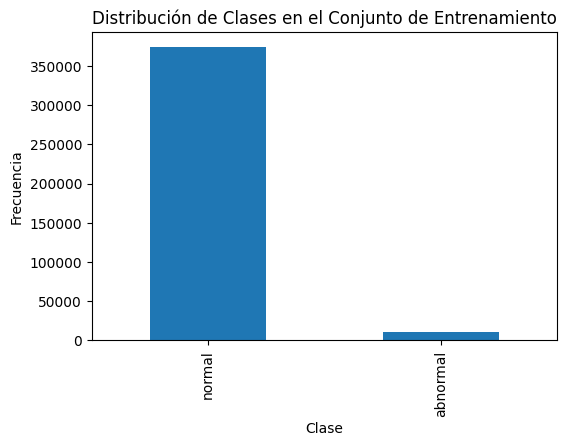

In [8]:
# distribución de las clases
class_distribution = train_df["class"].value_counts()

plt.figure(figsize=(6,4))
class_distribution.plot(kind='bar')
plt.title('Distribución de Clases en el Conjunto de Entrenamiento')
plt.xlabel('Clase')
plt.ylabel('Frecuencia')
plt.show()

In [9]:
# largo de secuencias
train_df['sequence_length'] = train_df['sequence'].apply(lambda x: len(eval(x)))

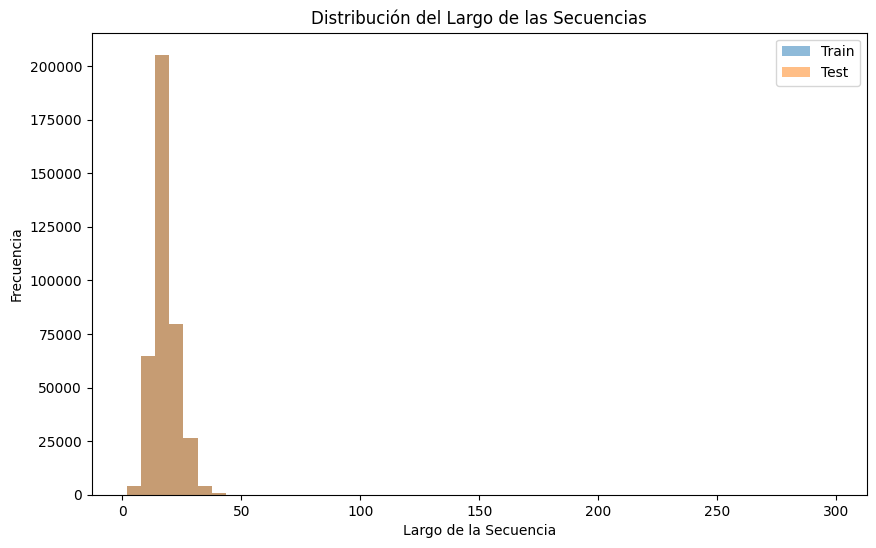

Secuencia más larga: 298
Secuencia más corta: 2


In [10]:
# tiene algo que ver el largo de la secuencia con si es normal o anormal?

plt.figure(figsize=(10,6))
plt.hist(train_df['sequence_length'], bins=50, alpha=0.5, label='Train')
plt.hist(train_df['sequence_length'], bins=50, alpha=0.5, label='Test')
plt.title('Distribución del Largo de las Secuencias')
plt.xlabel('Largo de la Secuencia')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

print(f"Secuencia más larga: {train_df['sequence_length'].max()}")
print(f"Secuencia más corta: {train_df['sequence_length'].min()}")

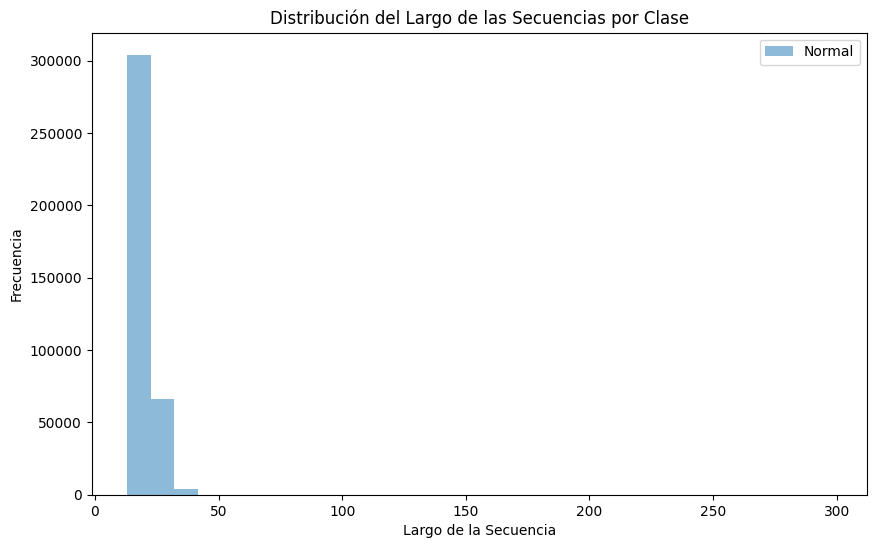

Secuencia más larga: 298
Secuencia más corta: 13


In [11]:
plt.figure(figsize=(10,6))

# Histograma para la clase "normal"
plt.hist(train_df[train_df['class'] == 'normal']['sequence_length'], bins=30, alpha=0.5, label='Normal')

plt.title('Distribución del Largo de las Secuencias por Clase')
plt.xlabel('Largo de la Secuencia')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

print(f"Secuencia más larga: {train_df[train_df['class'] == 'normal']['sequence_length'].max()}")
print(f"Secuencia más corta: {train_df[train_df['class'] == 'normal']['sequence_length'].min()}")


In [ ]:
plt.figure(figsize=(10,6))

# Histograma para la clase "abnormal"
plt.hist(train_df[train_df['class'] == 'abnormal']['sequence_length'], bins=30, alpha=0.5, label='Abnormal')

plt.title('Distribución del Largo de las Secuencias por Clase')
plt.xlabel('Largo de la Secuencia')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

print(f"Secuencia más larga: {train_df[train_df['class'] == 'abnormal']['sequence_length'].max()}")
print(f"Secuencia más corta: {train_df[train_df['class'] == 'abnormal']['sequence_length'].min()}")

¿Qué valores tienen los datos? 

In [13]:
# Convertir las secuencias de string a listas y obtener una lista de listas
all_sequences = train_df['sequence'].apply(lambda x: list(eval(x)))

# Aplanar la lista de listas para tener una lista de todos los elementos de todas las secuencias
all_elements = [item for sublist in all_sequences for item in sublist]

# Encontrar el valor mínimo y máximo
min_value = min(all_elements)
max_value = max(all_elements)

print(f"Valor mínimo de las secuencias: {min_value}")
print(f"Valor máximo de las secuencias: {max_value}")


Valor mínimo de las secuencias: 0
Valor máximo de las secuencias: 27


## Preprocesamiento de Datos

Dado que vamos a necesitar una sequencia de logs de longitud fija para entrenar el modelo, realizaremos un preprocesamiento de los datos para convertir las secuencias de logs en tensores de longitud fija. Además, como el valor minimos de la secuencia es 0 vamos a dejar lo en base 1 (sumando 1 a cada valor). De esa manera reservamos el 0 para hacer padding.

Preguntas relevantes:
- ¿Qué es más importante, el principio o el final de la secuencia?
- ¿Qué longitud de secuencia es adecuada para capturar la información relevante?
- ¿Hacer left-padding o right-padding?

In [14]:
SEQ_LEN = 50  # Longitud de las secuencias con las que vamos a trabajar. Secuencia larga en RNN da PEORES resultados por eso no usamos el maximo
PADDING_VALUE = 0  # Valor usado para hacer padding. Valor asignado a "no valor"

# para saber donde cortar tengo que probar y ver donde esta la informacion util, al principio de la secuencia, al final, al medio...?

# truncating me dice con que me quedo cuando corto

# padding value lo ponemos en 0, por mas que ya existe como valor, porque da igual a la hora de entrenar, al embedding no le importa
# aca lo resolvemos sumando 1 apenas arranca el preprocess asi todos pasan a valer 1 mas y el 0 queda libre
# lo hizo asi porque se usa el 0 para el padding por convencion, pero daria lo mismo el entrenamiento si usabamos un 28, que esta
# fuera de los valores del datasets
# lo que tiene que cumplir es que este entre 0 y N, numeros negativos no porque se usan como indices de array despues

def preprocess_sequence(sequence, max_len=SEQ_LEN, truncating='post', padding_value=PADDING_VALUE, padding='left'):
    # Convertir la secuencia de string a lista de enteros (en base 1)
    sequence = [x + 1 for x in eval(sequence)]
    
    # Si la secuencia es más larga que max_len, la truncamos 
    if len(sequence) > max_len:
        if truncating == 'post':
            sequence = sequence[:max_len]
        else:
            sequence = sequence[-max_len:]
    
    # Si la secuencia es más corta que max_len, añadimos padding
    if len(sequence) < max_len:
        padding_size = max_len - len(sequence)
        
        if padding == 'right':
            sequence = sequence + [padding_value] * padding_size
        else:
            sequence = [padding_value] * padding_size + sequence
    
    return sequence

# Aplicamos el preprocesamiento a todas las secuencias en el DataFrame
train_df['padded_sequence'] = train_df['sequence'].apply(lambda x: preprocess_sequence(x, truncating='pre', padding='left'))
test_df['padded_sequence'] = test_df['sequence'].apply(lambda x: preprocess_sequence(x, truncating='pre', padding='left'))

# Ver el resultado
print(train_df[['sequence', 'padded_sequence']].head())

                                            sequence  \
0  (4, 4, 4, 21, 10, 8, 10, 8, 10, 8, 25, 25, 25,...   
1  (4, 4, 4, 21, 10, 8, 25, 10, 8, 10, 8, 25, 25,...   
2  (21, 4, 4, 4, 25, 25, 10, 8, 25, 10, 8, 10, 8,...   
3  (21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25,...   
4  (21, 4, 4, 4, 25, 25, 25, 10, 8, 10, 8, 10, 8,...   

                                     padded_sequence  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  


## Dataset y Dataloaders

In [15]:
class LogDataset(Dataset):
    def __init__(self, sequences, labels):
        """
        Args:
            sequences (list of lists): Secuencias preprocesadas.
            labels (list): Etiquetas correspondientes (e.g., 0 para normal, 1 para abnormal).
        """
        self.sequences = sequences  # Las secuencias preprocesadas (padded)
        self.labels = labels  # Las etiquetas (normal, abnormal)

    def __len__(self):
        # Devuelve la longitud del dataset (número de secuencias)
        return len(self.sequences)

    def __getitem__(self, idx):
        # Devuelve una secuencia y su etiqueta correspondiente
        # importante pasar a long porque el embedding NO recibe float
        sequence = torch.tensor(self.sequences[idx], dtype=torch.long)  # Convertimos la secuencia a tensor
        label = torch.tensor(self.labels[idx], dtype=torch.long)  # Convertimos la etiqueta a tensor
        return sequence, label

Vamos a usar `sklearn.model_selection.train_test_split` para dividir el dataset en conjuntos de entrenamiento y validación ya que el dataset esta desbalanceado.

In [16]:
sequences = train_df['padded_sequence'].tolist()  # Lista de secuencias preprocesadas
labels = [0 if cls == 'normal' else 1 for cls in train_df['class']]  # Etiquetas convertidas a 0 y 1

# Dividir las secuencias y las etiquetas en entrenamiento y prueba
# manteniendo la proporción de clases (stratify=labels)
train_seq, val_seq, train_labels, val_labels = train_test_split(sequences, labels, test_size=0.2, random_state=SEED, stratify=labels)

train_dataset = LogDataset(train_seq, train_labels)
val_dataset = LogDataset(val_seq, val_labels)

In [17]:
test_seq = test_df['padded_sequence'].tolist()
test_labels = [0 if cls == 'normal' else 1 for cls in test_df['class']]
test_dataset = LogDataset(test_seq, test_labels)

In [18]:
def get_data_loaders(batch_size):

    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS
    )

    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS
    )

    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS
    )

    return train_loader, val_loader, test_loader

In [19]:
train_loader, val_loader, test_loader = get_data_loaders(BATCH_SIZE)

## Modelado

Dado que nuestro dataset está desbalanceado, usaremos ponderación de clases.

In [20]:
class_counts = Counter(train_labels)
total = sum(class_counts.values())
class_weights = {cls: total/count for cls, count in class_counts.items()}
class_weights = torch.tensor([class_weights[0], class_weights[1]], dtype=torch.float).to(DEVICE)

print(f"Class Weights: {class_weights}")

Class Weights: tensor([ 1.0302, 34.1530], device='cuda:0')


In [21]:
CRITERION = nn.CrossEntropyLoss(weight=class_weights).to(DEVICE)  # función de pérdida con pesos para cada clase
LR = 0.0005
EPOCHS = 20

### nn.Embedding

La [capa de embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) en PyTorch es una capa lineal que mapea un índice a un vector de características. Por ejemplo, si nuestro vocabulario tiene 100 palabras/simbolos y estamos utilizando un embedding de tamaño 20, la capa de embedding tendrá una matriz de pesos de tamaño 100 x 20. Dado un índice de palabra, la capa de embedding devuelve la fila correspondiente de la matriz de pesos, que es el vector de características de la palabra.

Pregunta relevante:
- ¿Qué tamaño de embedding es adecuado para nuestros logs? Regla general: usasr la raiz cuadrada del vocabulario o el logaritmo (base 2) del vocabulario.

In [28]:
VOCAB_SIZE = max_value + 2 # Tamaño del vocabulario (+1 por el padding, +1 porque los índices empiezan en 1)
# vocab size es la cantidad de filas

EMBEDDING_DIM = 8  # Dimensión del embedding -> cantidad de columnas
# cada fila del embedding es una palabra
# una capa de embedding es una matriz...  todo lo que no sea padding, empieza con pesos aleatorios
# las columnas serian las caracteristicas que distinguen a cada elemento

# si elegi padding_value 0 significa que la fila 0 va a estar clavada siempre en 0 0 0 0 

embedding_layer = nn.Embedding(
    VOCAB_SIZE, EMBEDDING_DIM, padding_idx=PADDING_VALUE # Los pesos correspondientes al padding no se actualizan
)
word_indices = torch.tensor([0, 1, 2, 3, 4, 5], dtype=torch.int32) # <- IMPORTANTE: la capa de embedding espera tensores de tipo long/enteros
embedded = embedding_layer(word_indices)

print(f"Word indices: {word_indices}")
print(f"Embedded: {embedded}")

Word indices: tensor([0, 1, 2, 3, 4, 5], dtype=torch.int32)
Embedded: tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [-0.7495,  1.0314,  0.4657, -0.7520, -0.2013, -1.8805, -1.0088, -0.2748],
        [-0.6930,  0.1942, -1.0275, -2.7594,  1.1561, -2.0756,  0.9104,  1.7717],
        [ 0.5372, -0.3934,  0.3451, -0.4792, -1.0948,  0.1799,  0.1264, -0.1711],
        [-1.0613, -0.3522,  1.8412,  0.5613,  0.0212, -0.4811, -0.1250, -1.7354],
        [ 1.0484,  0.5002, -1.6921,  2.3536, -0.2939, -0.4582,  0.1709,  1.0591]],
       grad_fn=<EmbeddingBackward0>)


In [29]:
word_indices = torch.tensor([2, 10, 50], dtype=torch.int32)
# embedding_layer(word_indices) # por qué falla? porque estas accediendo a un valor que no existe, el 50 no esta en la matriz

### nn.RNN

La capa [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html) en PyTorch es una capa recurrente que procesa una secuencia de entrada paso a paso, manteniendo un estado oculto que captura la información de pasos anteriores. Dado un tensor de entrada de tamaño `(batch, secuencia, características)`, la capa RNN procesa la secuencia paso a paso y devuelve el estado oculto final para cada secuencia en el lote.

<!-- ![rnn](https://d2l.ai/_images/rnn.svg) -->
<img src="https://d2l.ai/_images/rnn.svg" width="500" style="background:white; display: block; margin-left: auto; margin-right: auto;"/>

**Fórmula Matemática de la RNN**

Según la [documentación oficial de PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html), para cada paso temporal $t$, una RNN calcula:

$$h_t = \tanh( x_t W_{ih}^T + b_{ih} +  h_{t-1} W_{hh}^T + b_{hh})$$

Se puede usar cualquier función de activación pero esta es la más usada.

Donde:
- $x_t$ es la entrada en el tiempo $t$ (shape: `input_size`)
- $h_{t-1}$ es el estado oculto del paso anterior (shape: `hidden_size`)
- $h_t$ es el nuevo estado oculto (shape: `hidden_size`)
- $W_{ih}$ son los pesos input-to-hidden (shape: `hidden_size × input_size`)
- $W_{hh}$ son los pesos hidden-to-hidden (shape: `hidden_size × hidden_size`)
- $b_{ih}$ y $b_{hh}$ son los biases (shape: `hidden_size`)

> Notar que tiene dos términos de bias pero podría ser uno solo.

**Parámetros de la RNN**

Vamos a crear una RNN muy pequeña para hacer las cuentas a mano

In [30]:
batch_size = 1   # un solo ejemplo
seq_len = 2      # secuencia de solo 2 pasos
input_size = 3   # cantidad de características de entrada
hidden_size = 4  # dimensión del hidden state

# Crear la RNN
rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True) # por defecto batch_first=False

print("=== PARÁMETROS DE LA RNN ===\n")
for name, param in rnn.named_parameters():
    print(f"{name}:")
    print(f"  Shape: {param.shape}")
    print(f"  Valores:\n{param.data}\n")

=== PARÁMETROS DE LA RNN ===

weight_ih_l0:
  Shape: torch.Size([4, 3])
  Valores:
tensor([[ 0.0485, -0.1986,  0.0166],
        [ 0.4201,  0.0364, -0.4968],
        [-0.1008, -0.0018, -0.2269],
        [ 0.1753, -0.2860, -0.1456]])

weight_hh_l0:
  Shape: torch.Size([4, 4])
  Valores:
tensor([[-0.0147, -0.1439,  0.4874,  0.3249],
        [-0.0580,  0.1963,  0.1289, -0.4094],
        [-0.2449, -0.4826, -0.3381, -0.1091],
        [ 0.4940,  0.4193,  0.4828,  0.3909]])

bias_ih_l0:
  Shape: torch.Size([4])
  Valores:
tensor([ 0.0773,  0.0667, -0.0420,  0.1029])

bias_hh_l0:
  Shape: torch.Size([4])
  Valores:
tensor([-0.4652, -0.1245,  0.2904, -0.3649])



In [33]:
x = torch.tensor([
    [[1.0, 2.0, 3.0],   # paso temporal t=0
     [0.5, 1.5, 2.5]]   # paso temporal t=1
])  # (batch_size, seq_len, input_size)

# esto simula la salida del embedding en cada lugar

# Extraer los parámetros
W_ih = rnn.weight_ih_l0.data  # (4, 3)
W_hh = rnn.weight_hh_l0.data  # (4, 4)
b_ih = rnn.bias_ih_l0.data    # (4,)
b_hh = rnn.bias_hh_l0.data    # (4,)

In [32]:
# Estado inicial (por defecto es cero)
x_0 = x[:, 0, :]  # (1, 3) - primera entrada
h_0 = torch.zeros(batch_size, hidden_size)  # (1, 4)

print("=== PASO TEMPORAL t=0 ===\n")
print(f"x_0: {x_0}")
print(f"h_0 (inicial): {h_0}\n")

# Paso 1: input contribution
input_contrib = x_0 @ W_ih.T + b_ih  # (1, 4)
print(f"Input contribution (x_0 @ W_ih.T + b_ih):\n{input_contrib}\n")

# Paso 2: hidden contribution
hidden_contrib = h_0 @ W_hh.T + b_hh  # (1, 4)
print(f"Hidden contribution (h_0 @ W_hh.T + b_hh):\n{hidden_contrib}\n")

# Paso 3: sumar y aplicar tanh
h_1 = torch.tanh(input_contrib + hidden_contrib)
print(f"h_1 = tanh(input_contrib + hidden_contrib):\n{h_1}\n")

=== PASO TEMPORAL t=0 ===

x_0: tensor([[1., 2., 3.]])
h_0 (inicial): tensor([[0., 0., 0., 0.]])

Input contribution (x_0 @ W_ih.T + b_ih):
tensor([[-0.2216, -0.9307, -0.8272, -0.7307]])

Hidden contribution (h_0 @ W_hh.T + b_hh):
tensor([[-0.4652, -0.1245,  0.2904, -0.3649]])

h_1 = tanh(input_contrib + hidden_contrib):
tensor([[-0.5959, -0.7838, -0.4905, -0.7989]])



In [34]:
x_1 = x[:, 1, :]  # (1, 3) - segunda entrada
h_1 = h_1  # (1, 4) - estado oculto del paso anterior

print("=== PASO TEMPORAL t=1 ===\n")
print(f"x_1: {x_1}")
print(f"h_1 (anterior): {h_1}\n")

# Paso 1: input contribution
input_contrib = x_1 @ W_ih.T + b_ih  # (1, 4)
print(f"Input contribution (x_1 @ W_ih.T + b_ih):\n{input_contrib}\n")

# Paso 2: hidden contribution
hidden_contrib = h_1 @ W_hh.T + b_hh  # (1, 4)
print(f"Hidden contribution (h_1 @ W_hh.T + b_hh):\n{hidden_contrib}\n")

# Paso 3: sumar y aplicar tanh
h_2 = torch.tanh(input_contrib + hidden_contrib)
print(f"h_2 = tanh(input_contrib + hidden_contrib):\n{h_2}\n")

=== PASO TEMPORAL t=1 ===

x_1: tensor([[0.5000, 1.5000, 2.5000]])
h_1 (anterior): tensor([[-0.5959, -0.7838, -0.4905, -0.7989]])

Input contribution (x_1 @ W_ih.T + b_ih):
tensor([[-0.1548, -0.9106, -0.6624, -0.6026]])

Hidden contribution (h_1 @ W_hh.T + b_hh):
tensor([[-0.8424,  0.0200,  1.0677, -1.5371]])

h_2 = tanh(input_contrib + hidden_contrib):
tensor([[-0.7604, -0.7117,  0.3844, -0.9727]])



Veamos si coincide con la implementación de PyTorch.

In [35]:
# Forward pass usando PyTorch
output, hidden = rnn(x)

print("=== OUTPUT DE PYTORCH ===")
print(f"Output shape: {output.shape}")  # (batch_size, seq_len, hidden_size)
print(f"Output:\n{output}\n")

print(f"Hidden shape: {hidden.shape}")  # (num_layers, batch_size, hidden_size)
print(f"Hidden:\n{hidden}\n")

=== OUTPUT DE PYTORCH ===
Output shape: torch.Size([1, 2, 4])
Output:
tensor([[[-0.5959, -0.7838, -0.4905, -0.7989],
         [-0.7604, -0.7117,  0.3844, -0.9727]]], grad_fn=<TransposeBackward1>)

Hidden shape: torch.Size([1, 1, 4])
Hidden:
tensor([[[-0.7604, -0.7117,  0.3844, -0.9727]]], grad_fn=<StackBackward0>)



In [41]:
rnn = nn.RNN(input_size=EMBEDDING_DIM, hidden_size=64, batch_first=True, num_layers=1) # si pongo mas layers es como una RNN por layer
tensor = torch.randn(BATCH_SIZE, SEQ_LEN, EMBEDDING_DIM)

output, hidden = rnn(tensor)
print(f"Output shape: {output.shape} (batch_size, seq_len, hidden_size)")
print(f"Hidden shape: {hidden.shape} (num_layers, batch_size, hidden_size)")

Output shape: torch.Size([256, 50, 64]) (batch_size, seq_len, hidden_size)
Hidden shape: torch.Size([1, 256, 64]) (num_layers, batch_size, hidden_size)


### Modelo

In [37]:
class HDFSClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes=2):
        super(HDFSClassifier, self).__init__()
        pass

    def forward(self, x):
        pass

summary(
    HDFSClassifier(VOCAB_SIZE, EMBEDDING_DIM, hidden_dim=128, num_classes=2),
    input_size=(BATCH_SIZE, SEQ_LEN),
    dtypes=[torch.long],
)

Layer (type:depth-idx)                   Output Shape              Param #
HDFSClassifier                           --                        --
Total params: 0
Trainable params: 0
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.10
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.10

### Entrenamiento y Evaluación

In [40]:
model = HDFSClassifier(VOCAB_SIZE, EMBEDDING_DIM, hidden_dim=128, num_classes=2).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

ValueError: optimizer got an empty parameter list

In [39]:
train_errors, val_errors = train(
    model,
    optimizer=optimizer,
    criterion=CRITERION,
    train_loader=train_loader,
    val_loader=val_loader,
    device=DEVICE,
    do_early_stopping=False,
    epochs=EPOCHS,
)

NameError: name 'optimizer' is not defined

In [ ]:
plot_training(train_errors, val_errors)

In [ ]:
model_classification_report(model, test_loader, DEVICE, 2, digits=4, do_confusion_matrix=True, do_balanced_accuracy=True)